# 3.01 Table Results

---

Author: Riley X. Brady

Date: 11/19/2020

This notebook pulls in post-processed data derived in the previous notebooks to calculate all of the values seen in Table 1 from the manuscript.

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import figutils
import proplot as plot
import gsw
import PyCO2SYS as pyco2

In [2]:
print(f"numpy: {np.__version__}")
print(f"xarray: {xr.__version__}")
print(f"proplot: {plot.__version__}")
print(f"gsw: {gsw.__version__}")
print(f"PyCO2SYS: {pyco2.__version__}")

numpy: 1.19.4
xarray: 0.16.1
proplot: 0.6.4
gsw: 3.4.0
PyCO2SYS: 1.6.0


**1. Percent of Antarctic Circumpolar Current (ACC) surface area covered by each region.**

Here, we are interested in quantifying how much of the ACC is covered by each of our topographic regions. This allows us to relate the percent of particles upwelled in each region to the area they cover.

To keep things simple, we calculate the area via the high-resolution unstructured Eulerian mesh areas.

In [3]:
# Mesh information for the Eulerian mesh.
mesh = xr.open_dataset("../data/mesh.nc")
area = mesh.areaCell
lat = np.rad2deg(mesh.latCell)
lon = np.rad2deg(mesh.lonCell)

In [4]:
# Sea ice to mask out annual sea ice zone.
ice = xr.open_dataset("../data/eulerian_sea_ice_climatology.nc")
ice = ice["icePresent"].mean("month")
ice_mask = ice < 0.75

In [5]:
# Calculate total area of ACC in m2.
# S of 45S and outside of annual sea ice zone.
total_area = area.where(ice_mask & (lat < -45)).sum(skipna=True)

Here, we compare the hexagonal mesh area of the given region to the total area of the ACC. The non-topographic regions of course cover the remainder of the ACC.

In [6]:
for region in ["drake", "crozet", "kerguelan", "campbell"]:
    x0, x1, y0, y1 = figutils.BOUNDS[region]
    # Drake is the only region west of the Prime Meridian, and
    # we are operating on a 0-360 grid so just need to convert it.
    if region == "drake":
        x0 += 360
        x1 += 360

    # Find grid cells within the region and outside of the sea ice zone.
    conditions = (lon > x0) & (lon < x1) & (lat > y0) & (lat < y1) & ice_mask
    regional_area = area.where(conditions).sum(skipna=True)

    pct_acc = np.round((regional_area / total_area).values * 100, 1)
    print(f"{region} percent of ACC: {pct_acc}%")

drake percent of ACC: 7.4%
crozet percent of ACC: 8.1%
kerguelan percent of ACC: 8.1%
campbell percent of ACC: 9.2%


In [7]:
non_topo_area = 100 - 7.4 - 8.1 - 8.1 - 9.2
print(f"non-topo: {non_topo_area}")

non-topo: 67.2


**2. N particles in the 1000 m crossing ensembles and percent of total upwelling.**

Here, we simply want to know how many particles belong to each ensemble based on where they last upwell across 1000 m in the ACC. Prior to hosting these notebooks, we post-processed the 1,000,000 global particles to those that last upwell across 1000 m outside of the annual sea ice, S of 45S, and ultimately reach 200 m before the simulation ends. So now we can just distribute them into their ensembles.

We also calculate the percent of total upwelled particles belonging to each ensemble to compare to the percent of the ACC covered by the region.

In [8]:
crossings = xr.open_dataset("../data/postproc/1000m.crossing.locations.nc")
xc, yc = crossings["lon_crossing"], crossings["lat_crossing"]

In [9]:
for region in ["drake", "crozet", "kerguelan", "campbell"]:
    x0, x1, y0, y1 = figutils.BOUNDS[region]
    # Drake is the only region west of the Prime Meridian, and
    # we are operating on a 0-360 grid so just need to convert it.
    if region == "drake":
        x0 += 360
        x1 += 360

    # Find grid cells within the region and outside of the sea ice zone.
    conditions = (xc > x0) & (xc < x1) & (yc > y0) & (yc < y1)

    N = crossings.where(conditions, drop=True).nParticles.size
    pct = np.round(N / crossings.nParticles.size * 100, 1)
    print(f"{region}: {N} particles; {pct}% of total upwelling")

drake: 5645 particles; 29.7% of total upwelling
crozet: 2050 particles; 10.8% of total upwelling
kerguelan: 2181 particles; 11.5% of total upwelling
campbell: 3651 particles; 19.2% of total upwelling


In [10]:
N_non_topo = crossings.nParticles.size - 5645 - 2050 - 2181 - 3651
pct = np.round(N_non_topo / crossings.nParticles.size * 100, 1)
print(f"non-topo: {N_non_topo}; {pct}% of total upwelling")

non-topo: 5475; 28.8% of total upwelling


**3. Zonal origin of DIC for the 1000 m crossing.**

Here, we look at where DIC originates from zonally for the 1000 m crossing. This is based on the memory time calculations done in notebook `1.03`.

In [11]:
def round_to_10(x):
    """Quick function to round to the nearest 10."""
    rem = x % 10
    if rem < 5:
        x = int(x / 10) * 10
    else:
        x = int((x + 10) / 10) * 10
    return x

drake...
286.4 +/- 39.6
4740 km
crozet...
23.0 +/- 30.4
4150 km
kerguelan...
71.4 +/- 26.0
3690 km
campbell...
142.8 +/- 35.8
4910 km


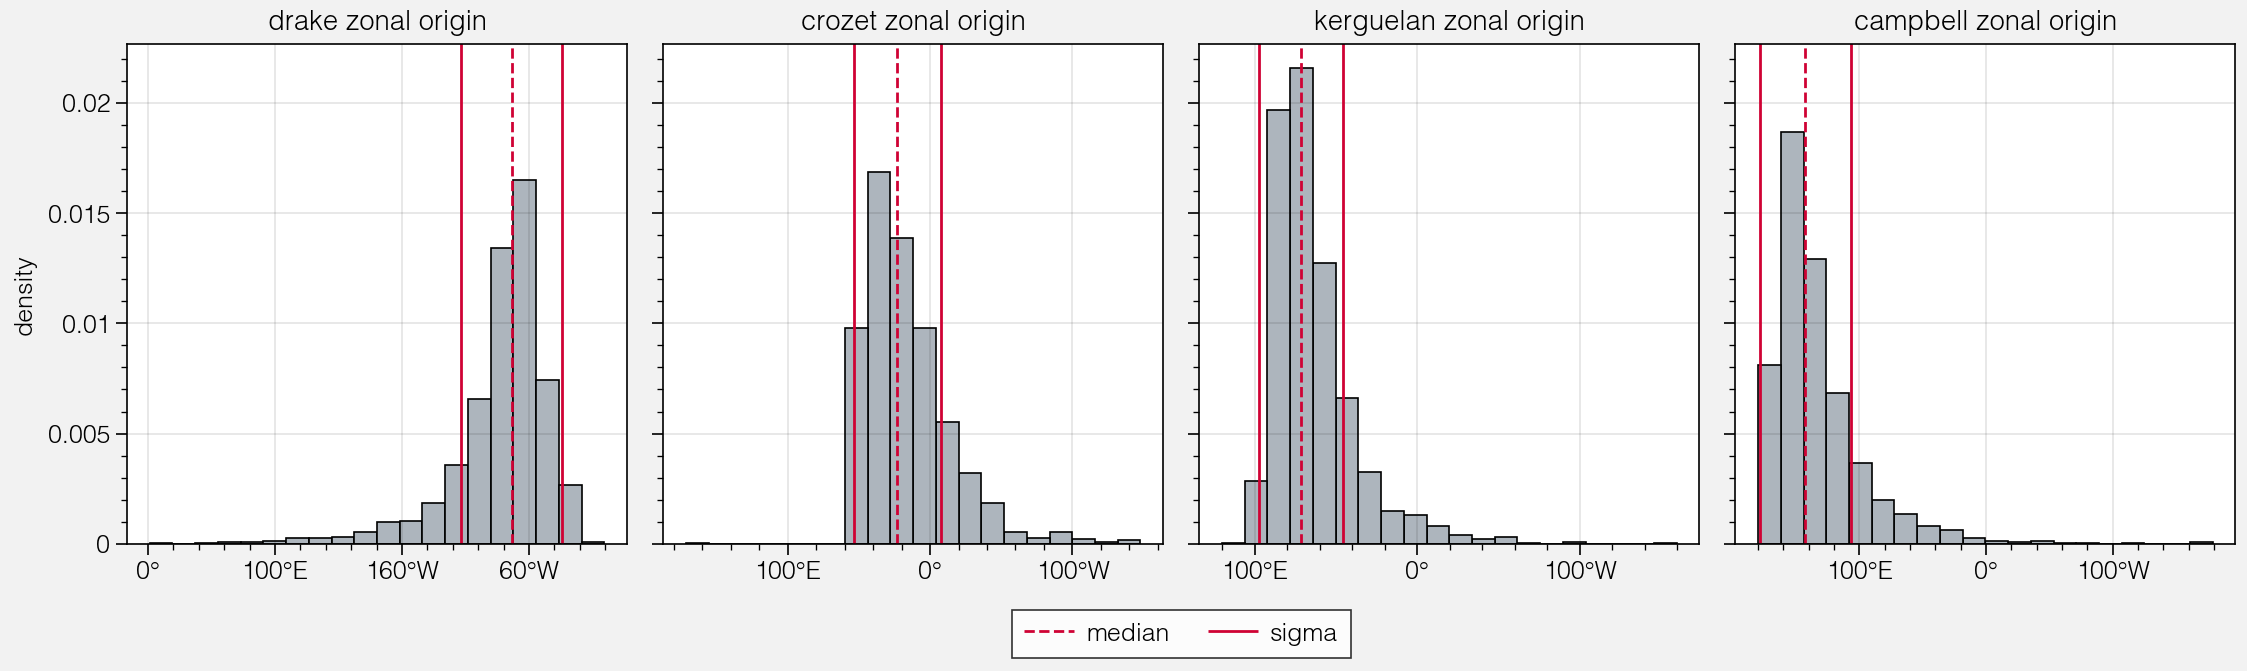

In [12]:
f, axs = plot.subplots(ncols=4)
for ax, region in zip(axs, ["drake", "crozet", "kerguelan", "campbell"]):
    origin = xr.open_dataset(f"../data/postproc/{region}.1000m.tracer.origin.nc")
    x = origin.x.values

    # Switch to -180 to 180 for continuous distribution over x axis.
    if region != "drake":
        x[x > 180] = x[x > 180] - 360

    # Take median and standard deviation of zonal distribution.
    xmedian = np.nanmedian(x)
    xsigma = np.nanstd(x)

    ax.hist(x, density=True, bins=20, color="gray5")
    p1 = ax.axvline(xmedian, color="cherry", ls="--", lw=1, label="median")
    p2 = ax.axvline(xmedian + xsigma, color="cherry", ls="-", lw=1, label="sigma")
    ax.axvline(xmedian - xsigma, color="cherry", ls="-", lw=1)
    ax.format(title=f"{region} zonal origin")

    print(f"{region}...")
    mu = np.round(xmedian, 1)
    sigma = np.round(xsigma, 1)
    print(f"{mu} +/- {sigma}")

    # Calculate zonal extent in km. Here we find the median latitude origin for the region
    # and then convert +/- 1 sigma to km from there.
    y = origin.y.values
    ymu = np.nanmedian(y)
    dist = 111 * np.cos(np.deg2rad(ymu)) * sigma * 2
    print(f"{round_to_10(dist)} km")

f.legend([p1, p2], loc="b")
axs.format(ylabel="density", xformatter="deglon")

**4. Meridional origin of DIC for 1000 m crossing.**

As in the previous exercise, but now for the meridional origin of DIC.

drake...
-57.4 +/- 4.3
950 km
crozet...
-52.1 +/- 3.6
800 km
kerguelan...
-50.3 +/- 5.8
1280 km
campbell...
-51.9 +/- 4.3
960 km


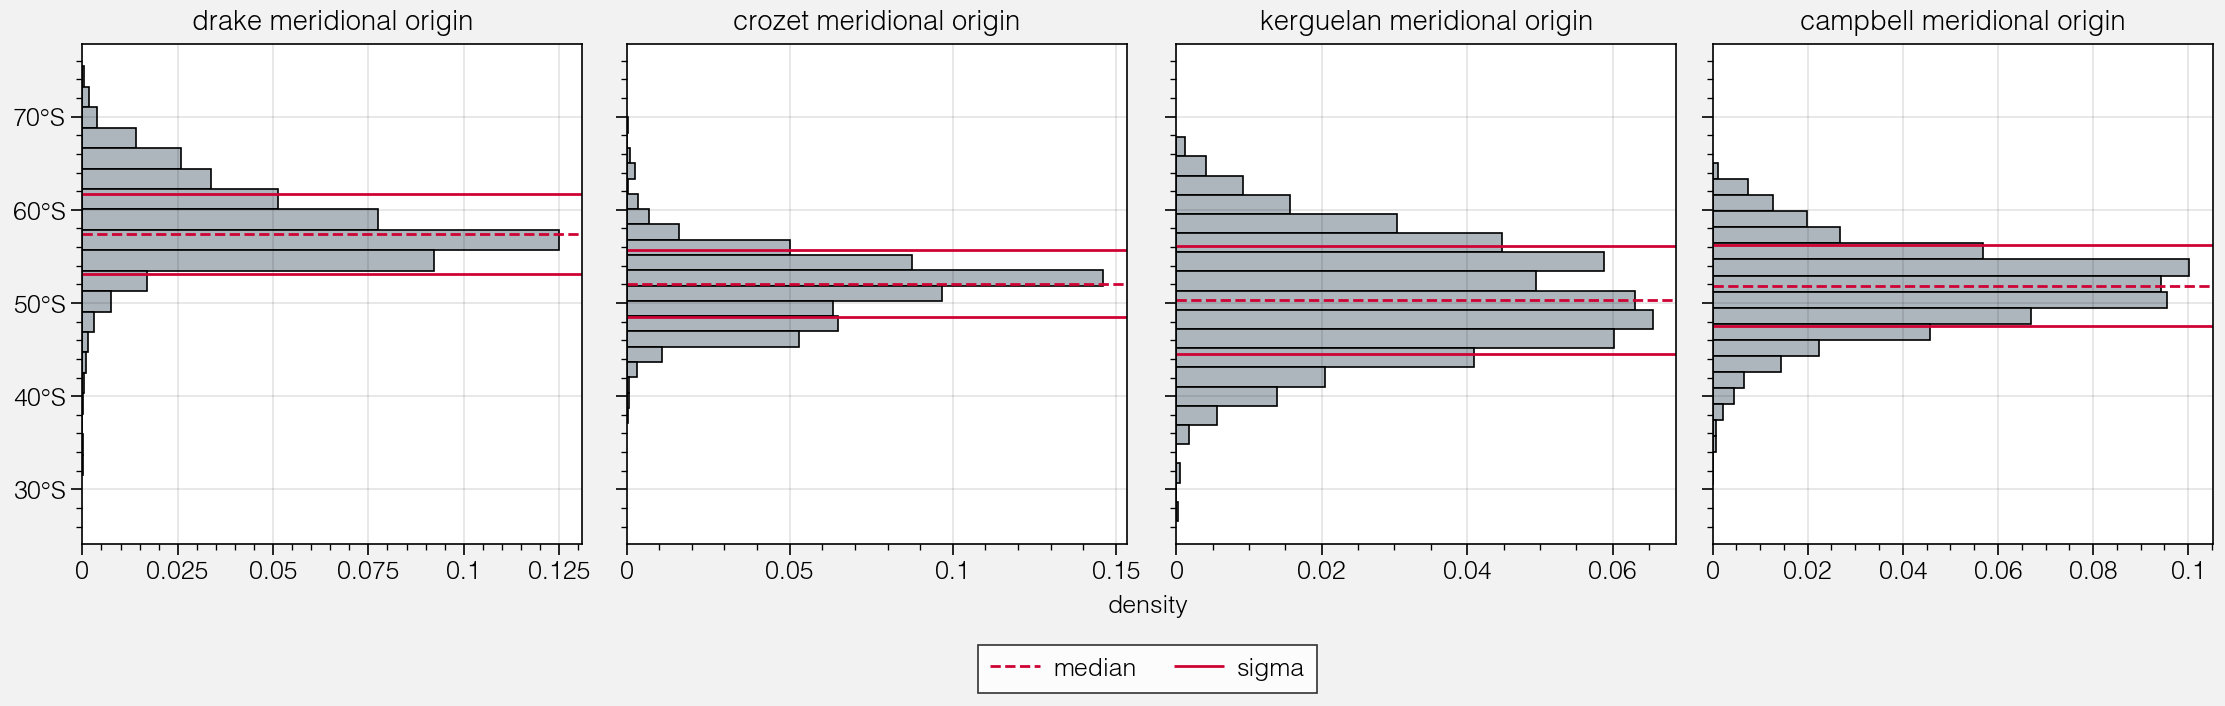

In [13]:
f, axs = plot.subplots(ncols=4)
for ax, region in zip(axs, ["drake", "crozet", "kerguelan", "campbell"]):
    origin = xr.open_dataset(f"../data/postproc/{region}.1000m.tracer.origin.nc")
    y = origin.y.values

    # Take median and standard deviation of zonal distribution.
    ymedian = np.nanmedian(y)
    ysigma = np.nanstd(y)

    ax.hist(y, density=True, orientation="horizontal", bins=20, color="gray5")
    p1 = ax.axhline(ymedian, color="cherry", ls="--", lw=1, label="median")
    p2 = ax.axhline(ymedian + ysigma, color="cherry", ls="-", lw=1, label="sigma")
    ax.axhline(ymedian - ysigma, color="cherry", ls="-", lw=1)
    ax.format(title=f"{region} meridional origin")

    print(f"{region}...")
    mu = np.round(ymedian, 1)
    sigma = np.round(ysigma, 1)
    print(f"{mu} +/- {sigma}")

    # Calculate meridional extent in km.
    dist = 111 * ysigma * 2
    print(f"{round_to_10(dist)} km")

f.legend([p1, p2], loc="b")
axs.format(xlabel="density", yformatter="deglat")

**5.Memory Time**

In [14]:
# Ignore numpy warnings about log
import warnings

warnings.filterwarnings("ignore")

drake...
366.0
crozet...
410.0
kerguelan...
382.0
campbell...
338.0
non_topographic...
366.0


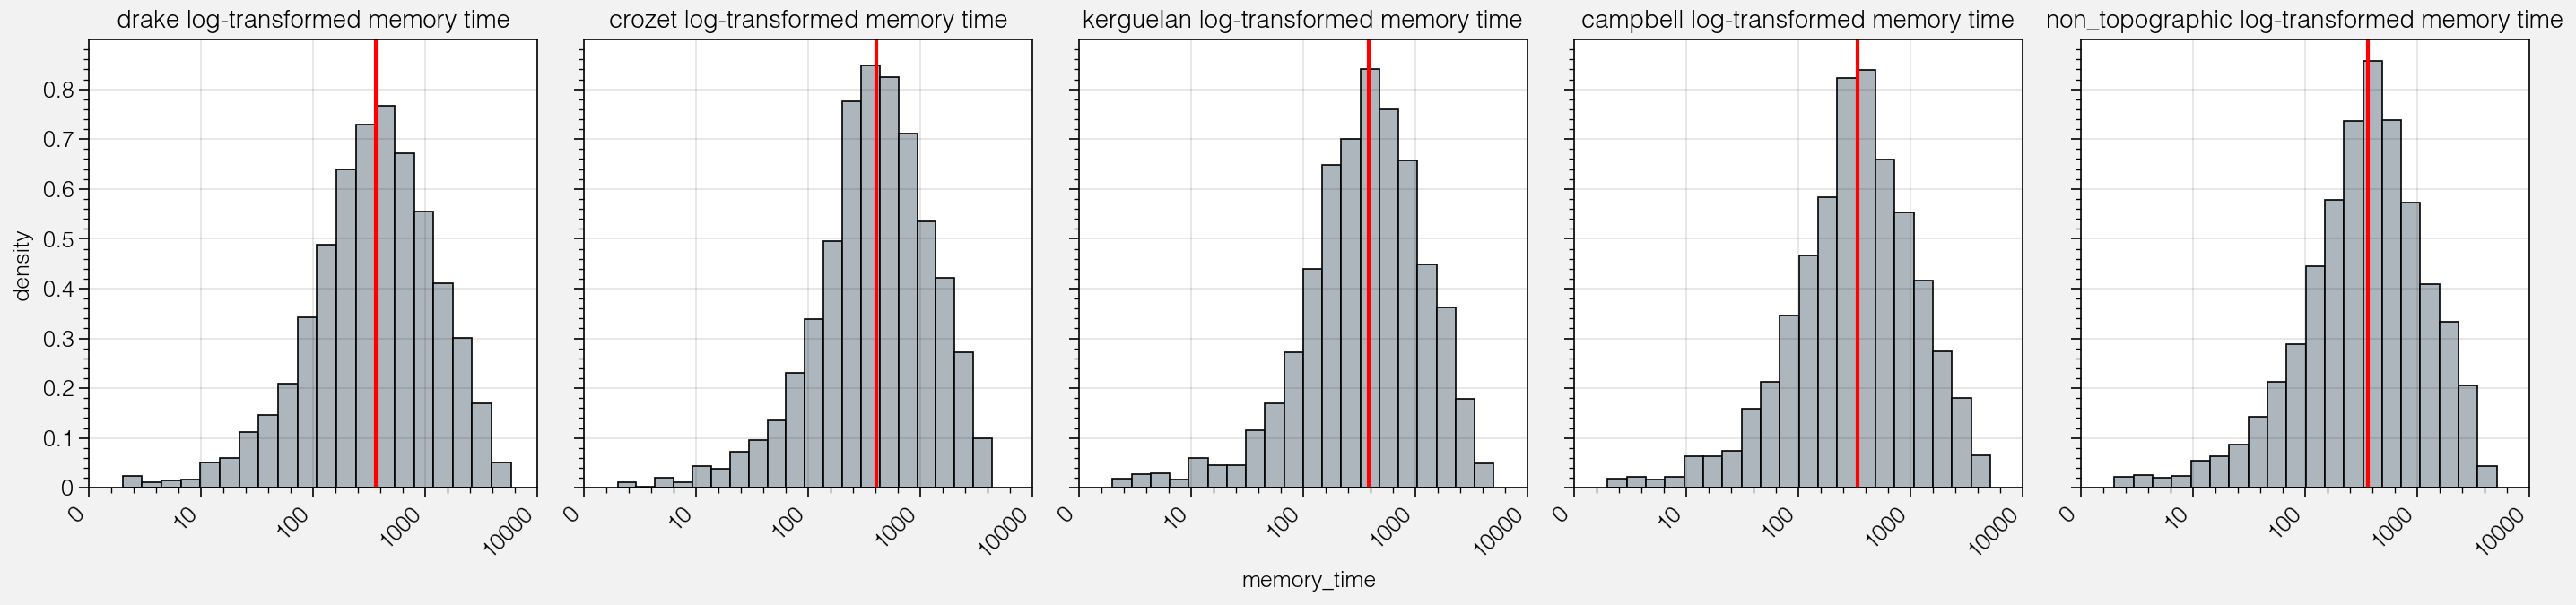

In [15]:
f, axs = plot.subplots(ncols=5)

for ax, region in zip(
    axs, ["drake", "crozet", "kerguelan", "campbell", "non_topographic"]
):
    origin = xr.open_dataset(f"../data/postproc/{region}.1000m.tracer.origin.nc")
    M = origin.memory_time.values
    print(f"{region}...")
    print(f"{np.round(np.nanmedian(M))}")

    # log is taken here since the data are log-distributred.
    ax.hist(np.log10(origin.memory_time), density=True, bins=20, color="gray5")
    ax.axvline(np.log10(np.nanmedian(M)), color="r")
    ax.format(title=f"{region} log-transformed memory time")

axs.format(
    xlim=(0, 4),
    xticks=[0, 1, 2, 3, 4],
    xticklabels=["0", "10", "100", "1000", "10000"],
    xrotation=45,
    ylabel="density",
)

**6. Tracer Concentrations at Origin**

Distribution of tracers at their source for the 1000 m crossing based on memory time.

Potential density

drake...
27.6 +/- 0.2
crozet...
27.6 +/- 0.1
kerguelan...
27.6 +/- 0.1
campbell...
27.5 +/- 0.2
non_topographic...
27.5 +/- 0.2


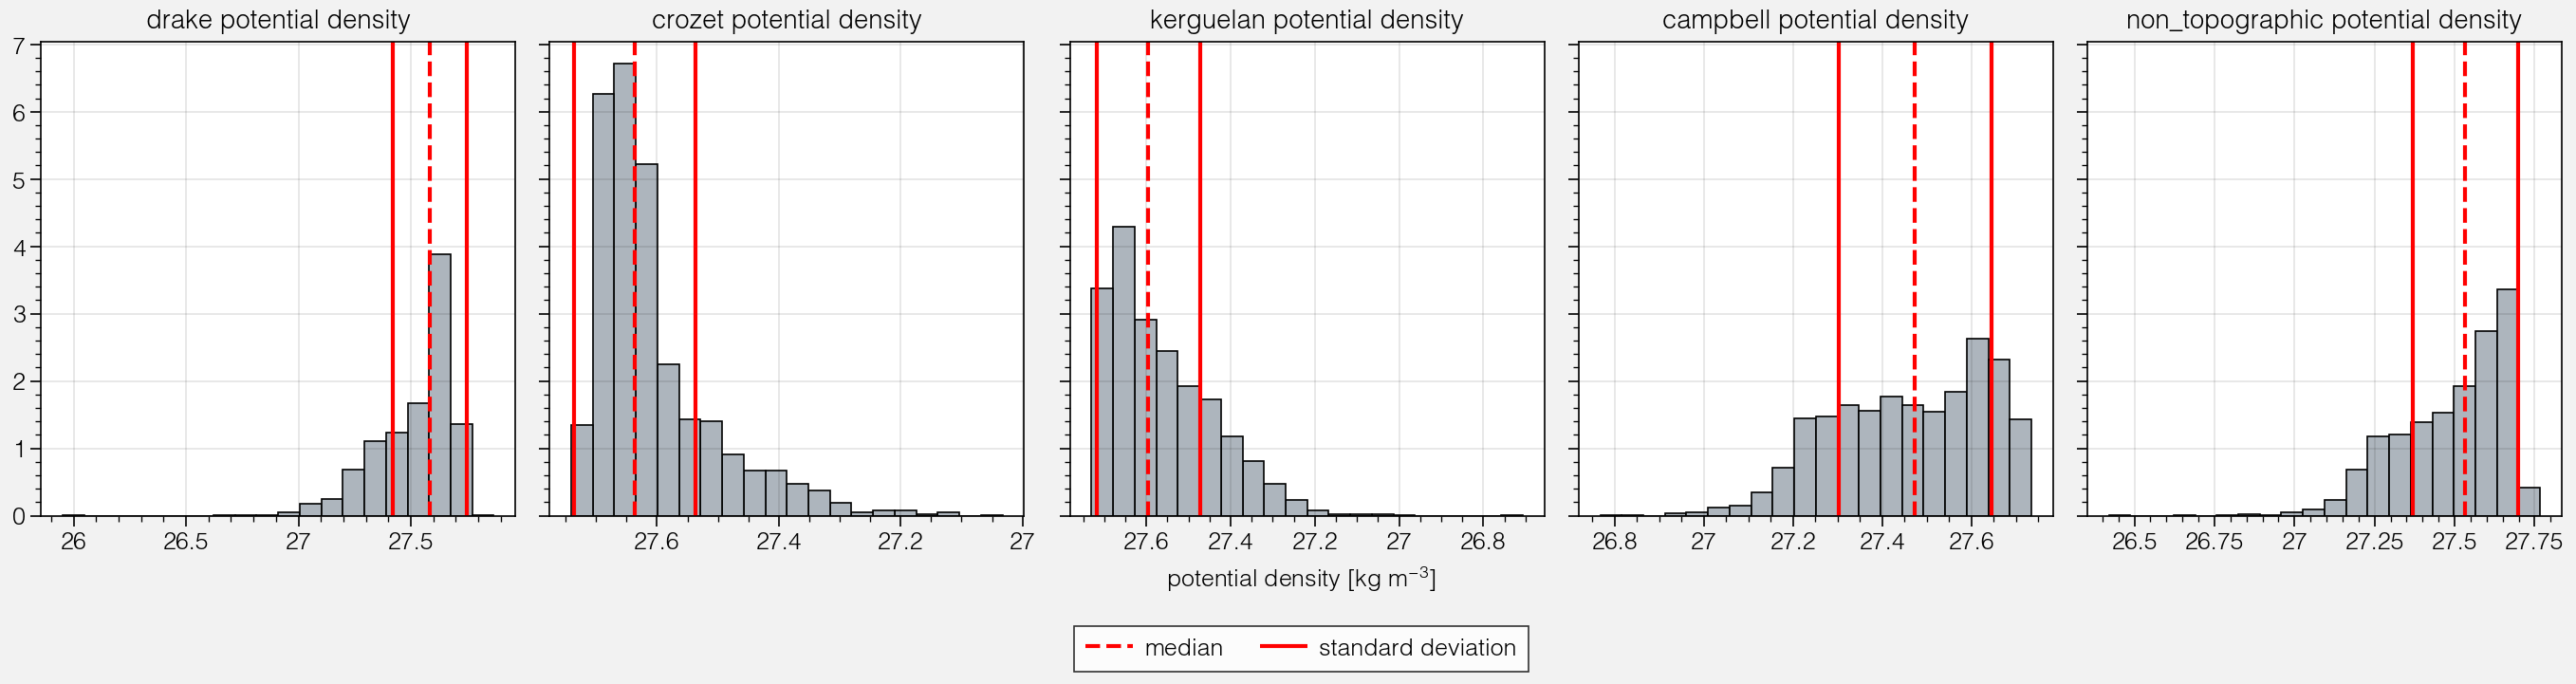

In [16]:
f, axs = plot.subplots(
    ncols=5,
)

for ax, region in zip(
    axs, ["drake", "crozet", "kerguelan", "campbell", "non_topographic"]
):
    origin = xr.open_dataset(f"../data/postproc/{region}.1000m.tracer.origin.nc")
    # Potential density
    sigma0 = gsw.sigma0(origin.S, origin.T)

    mu = sigma0.median().values
    sigma = sigma0.std().values
    print(f"{region}...")
    print(f"{np.round(mu, 1)} +/- {np.round(sigma, 1)}")

    ax.hist(sigma0, density=True, bins=20, color="gray5")
    ax.format(
        title=f"{region} potential density", xlabel="potential density [kg m$^{-3}$]"
    )
    p1 = ax.axvline(mu, color="r", ls="--", label="median")
    p2 = ax.axvline(mu - sigma, color="r", ls="-", label="standard deviation")
    ax.axvline(mu + sigma, color="r", ls="-")
f.legend([p1, p2], loc="b")

Dissolved inorganic carbon.

drake...
2220.0 +/- 23.0
crozet...
2220.0 +/- 15.0
kerguelan...
2217.0 +/- 13.0
campbell...
2212.0 +/- 21.0
non_topographic...
2218.0 +/- 21.0


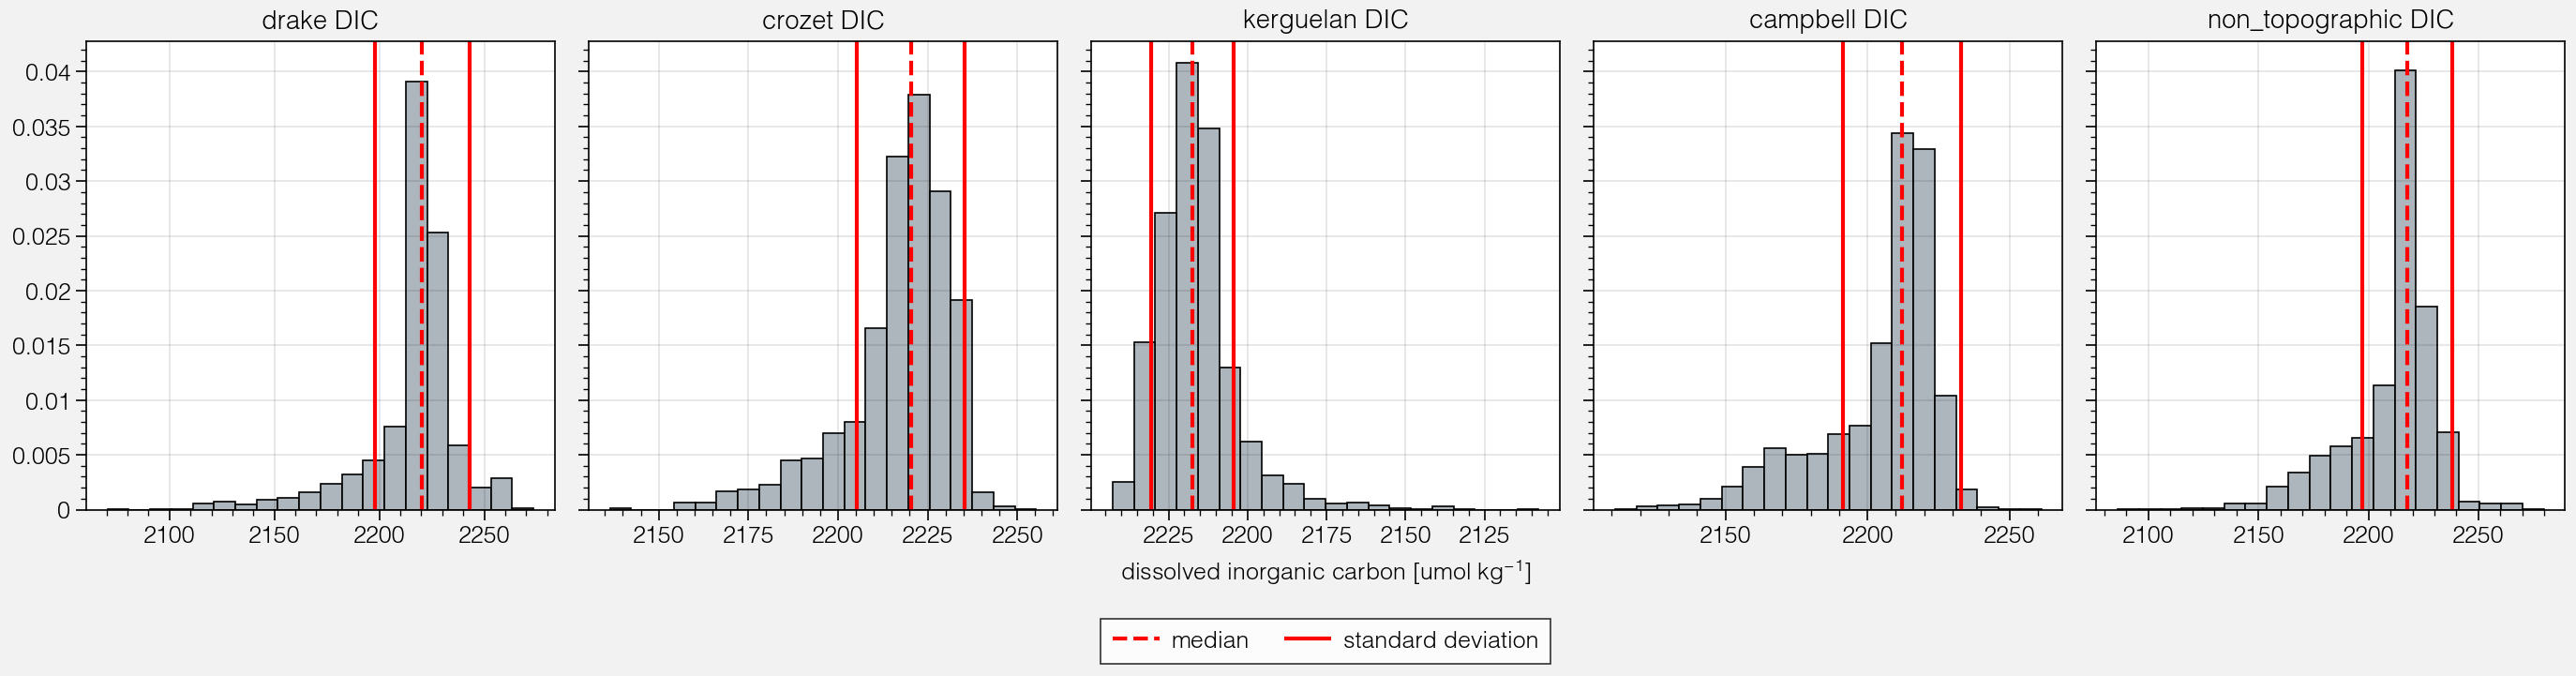

In [17]:
f, axs = plot.subplots(
    ncols=5,
)

for ax, region in zip(
    axs, ["drake", "crozet", "kerguelan", "campbell", "non_topographic"]
):
    origin = xr.open_dataset(f"../data/postproc/{region}.1000m.tracer.origin.nc")

    # Conversion to go from mmol m-3 to umol kg-1
    rho = gsw.density.rho(origin.S, origin.T, origin.z * -1)
    conversion = 1000 * (1 / rho)
    dic = origin.DIC * conversion

    mu = dic.median().values
    sigma = dic.std().values
    print(f"{region}...")
    print(f"{np.round(mu)} +/- {np.round(sigma)}")

    ax.hist(dic, density=True, bins=20, color="gray5")
    ax.format(
        title=f"{region} DIC", xlabel="dissolved inorganic carbon [umol kg$^{-1}$]"
    )
    p1 = ax.axvline(mu, color="r", ls="--", label="median")
    p2 = ax.axvline(mu - sigma, color="r", ls="-", label="standard deviation")
    ax.axvline(mu + sigma, color="r", ls="-")

f.legend([p1, p2], loc="b")

Potential pCO2.

drake...
486.0 +/- 51.0
crozet...
479.0 +/- 33.0
kerguelan...
481.0 +/- 27.0
campbell...
484.0 +/- 51.0
non_topographic...
482.0 +/- 44.0


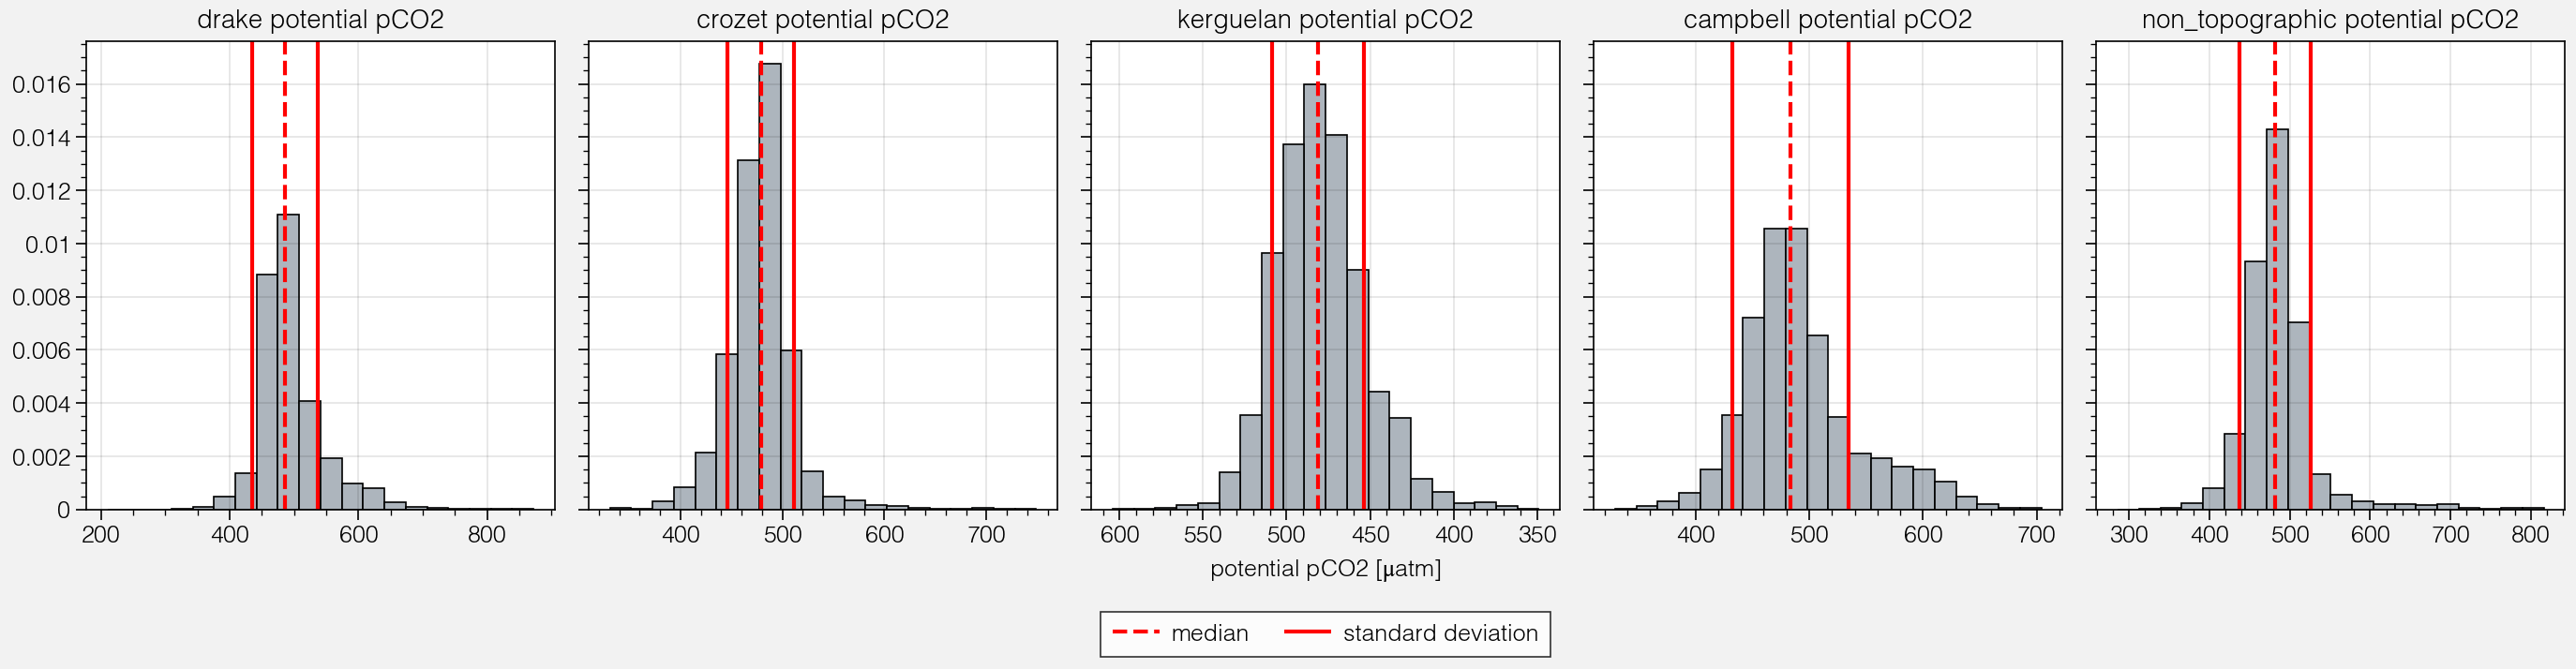

In [18]:
f, axs = plot.subplots(
    ncols=5,
)

for ax, region in zip(
    axs, ["drake", "crozet", "kerguelan", "campbell", "non_topographic"]
):
    origin = xr.open_dataset(f"../data/postproc/{region}.1000m.tracer.origin.nc")
    ambient = xr.open_dataarray(f"../data/postproc/{region}.ambient.temperature.nc")

    # Conversion to go from mmol m-3 to umol kg-1
    rho = gsw.density.rho(origin.S, origin.T, origin.z * -1)
    conversion = 1000 * (1 / rho)

    # Potential pCO2
    # need in situ (not potential) temperature for in situ pCO2
    t_insitu = gsw.pt_from_t(origin.S, origin.T, 0, origin.z * -1)

    # PyCO2SYS is a famous package from MATLAB. We're using the python plug-in here
    # to diagnostically calculate in situ pCO2 along the particle trajectory.
    pCO2 = pyco2.CO2SYS_nd(
        origin.ALK * conversion,
        origin.DIC * conversion,
        1,
        2,
        salinity=origin.S,
        temperature=t_insitu,
        pressure=origin.z * -1,
        total_silicate=origin.SiO3 * conversion,
        total_phosphate=origin.PO4 * conversion,
    )["pCO2"]

    # pCO2 if brought to the ambient temperature when the given particle upwells to
    # 200 m. We're just using a known lab-derived relationship that pCO2 varies by
    # ~4% for a degree change in temperature.f
    pCO2sigma = pCO2 * (1 + 0.0423 * (ambient.values - t_insitu.values))

    mu = np.nanmedian(pCO2sigma)
    sigma = np.nanstd(pCO2sigma)
    print(f"{region}...")
    print(f"{np.round(mu)} +/- {np.round(sigma)}")

    ax.hist(pCO2sigma, density=True, bins=20, color="gray5")
    ax.format(title=f"{region} potential pCO2", xlabel="potential pCO2 [$\mu$atm]")
    p1 = ax.axvline(mu, color="r", ls="--", label="median")
    p2 = ax.axvline(mu - sigma, color="r", ls="-", label="standard deviation")
    ax.axvline(mu + sigma, color="r", ls="-")

f.legend([p1, p2], loc="b")

**7. N particles in mixed layer ensembles**

Simply counting the number of particles that belong to the mixed layer ensembles, i.e., where they first cross 200 m after their last 1000 m crossing. Note that we lose some particles relative to the 1000 m ensemble, as they upwell into 200 m under the sea ice or N of 45S.

In [19]:
crossings = xr.open_dataset("../data/postproc/200m.crossing.locations.nc")
xc, yc = crossings["lon_crossing"], crossings["lat_crossing"]

In [20]:
for region in ["drake", "crozet", "kerguelan", "campbell"]:
    x0, x1, y0, y1 = figutils.BOUNDS[region]
    # Drake is the only region west of the Prime Meridian, and
    # we are operating on a 0-360 grid so just need to convert it.
    if region == "drake":
        x0 += 360
        x1 += 360

    # Find grid cells within the region and outside of the sea ice zone.
    conditions = (xc > x0) & (xc < x1) & (yc > y0) & (yc < y1)

    N = crossings.where(conditions, drop=True).nParticles.size
    pct = np.round(N / crossings.nParticles.size * 100, 1)
    print(f"{region}: {N} particles; {pct}% of total upwelling")

drake: 3104 particles; 25.2% of total upwelling
crozet: 1646 particles; 13.4% of total upwelling
kerguelan: 1632 particles; 13.3% of total upwelling
campbell: 1393 particles; 11.3% of total upwelling


In [21]:
N_non_topo = crossings.nParticles.size - 3104 - 1646 - 1632 - 1393
pct = np.round(N_non_topo / crossings.nParticles.size * 100, 1)
print(f"non-topo: {N_non_topo}; {pct}% of total upwelling")

non-topo: 4526; 36.8% of total upwelling


**8. Decorrelation timescale and residence time**

Evaluating the decorrelation time scale of DIC in the mixed layer and the mixed layer residence time (see notebook `1.05`)

drake...
44.0
crozet...
44.0
kerguelan...
44.0
campbell...
42.0
non_topographic...
40.0


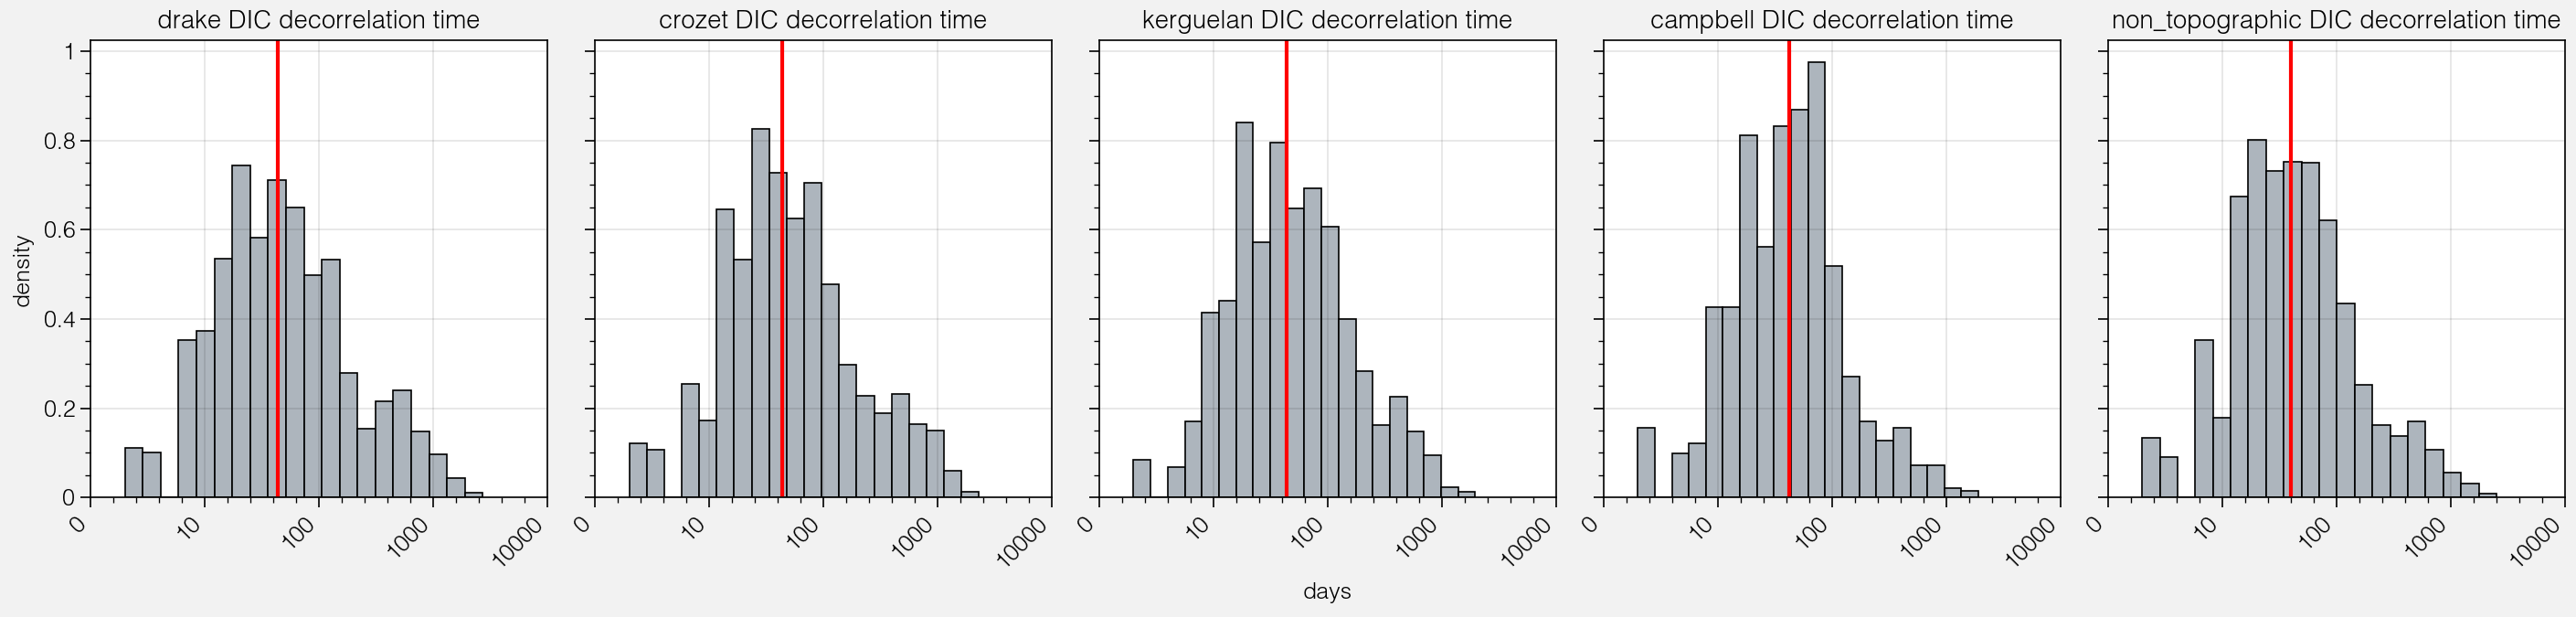

In [22]:
f, axs = plot.subplots(ncols=5)

for ax, region in zip(
    axs, ["drake", "crozet", "kerguelan", "campbell", "non_topographic"]
):
    result = xr.open_dataset(f"../data/postproc/{region}.DIC.decorr.nc")
    decorr = result.decorr.values
    print(f"{region}...")
    print(f"{np.round(np.nanmedian(decorr))}")

    # log is taken here since the data are log-distributed
    ax.hist(np.log10(decorr), density=True, bins=20, color="gray5")
    ax.axvline(np.log10(np.nanmedian(decorr)), color="r")
    ax.format(title=f"{region} DIC decorrelation time")

axs.format(
    xlim=(0, 4),
    xticks=[0, 1, 2, 3, 4],
    xticklabels=["0", "10", "100", "1000", "10000"],
    xrotation=45,
    xlabel="days",
    ylabel="density",
)

drake...
6.0
crozet...
6.0
kerguelan...
8.0
campbell...
8.0
non_topographic...
8.0


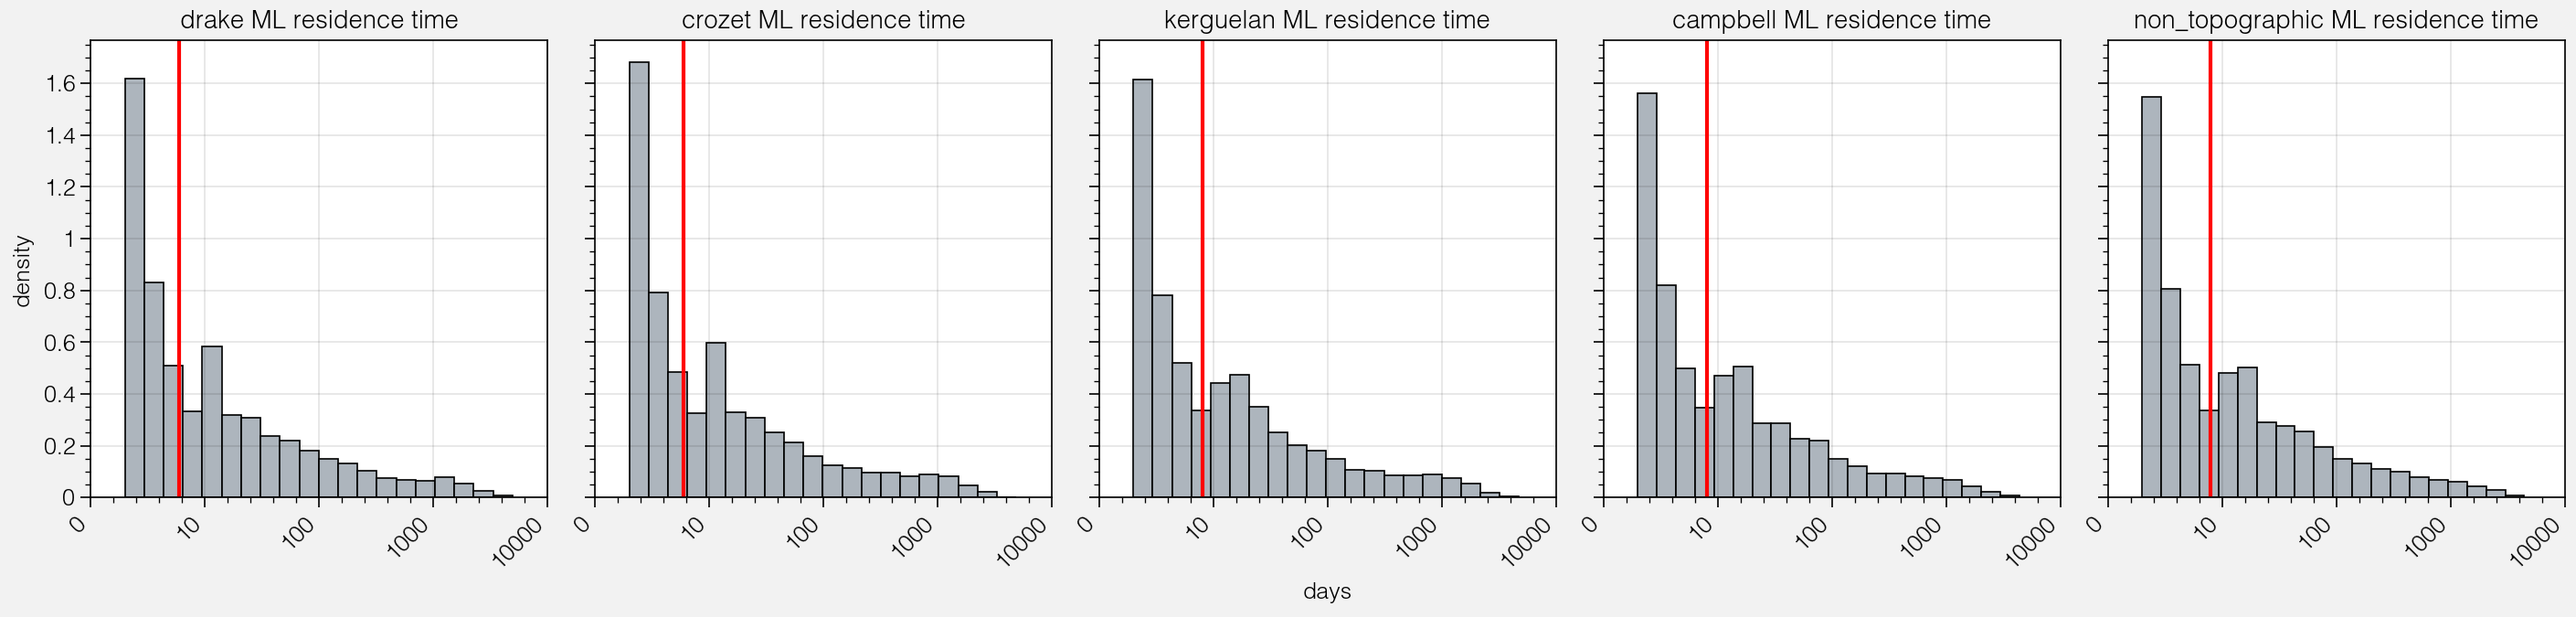

In [23]:
f, axs = plot.subplots(ncols=5)

for ax, region in zip(
    axs, ["drake", "crozet", "kerguelan", "campbell", "non_topographic"]
):
    result = xr.open_dataset(f"../data/postproc/{region}.tau.surface.nc")
    tau = result.tau.values
    print(f"{region}...")
    print(f"{np.round(np.nanmedian(tau))}")

    # log is taken here since the data are log-distributed. well, they
    # don't end up normal, but we're using the median anyhow, which is identical
    # between the transformed and non-transformed data.
    ax.hist(np.log10(tau), density=True, bins=20, color="gray5")
    ax.axvline(np.log10(np.nanmedian(tau)), color="r")
    ax.format(title=f"{region} ML residence time")

axs.format(
    xlim=(0, 4),
    xticks=[0, 1, 2, 3, 4],
    xticklabels=["0", "10", "100", "1000", "10000"],
    xrotation=45,
    xlabel="days",
    ylabel="density",
)